# Sales strategy analysis for "Pens and Printers"

We are tasked with analyzing the effectiveness of three sales strategies used by "Pens and Printers" for their new stationery product line. By evaluating customer reach and revenue generation, our goal is to recommend the optimal sales approach to enhance future product launches.

## 1. Import packages

In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from scipy import stats
from datetime import datetime

# render figures in notebook
%matplotlib inline

## 2. Load dataset and data preview

In [2]:
# load dataset
data = pd.read_csv('product_sales.csv')

In [3]:
# preview first rows
data.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


## 3. Initial basic EDA

In [4]:
# data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [5]:
# basic statistics (numeric variables)
data.describe()

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000000,15000.000000,13926.000000,15000.000000,15000.000000
mean,3.098267,10.084667,93.934943,4.965933,24.990867
std,1.656420,1.812213,47.435312,5.044952,3.500914
min,1.000000,7.000000,32.540000,0.000000,12.000000
25%,2.000000,9.000000,52.470000,1.000000,23.000000
50%,3.000000,10.000000,89.500000,3.000000,25.000000
75%,5.000000,11.000000,107.327500,7.000000,27.000000
max,6.000000,16.000000,238.320000,63.000000,41.000000


From the initial basic EDA we know that:

- the dataset has 15'000 entries
- the dataset has 8 columns: 'week', 'sales_method', 'customer_id', 'nb_sold', 'revenue', 'years_as_customer', 'nb_site_visits' and 'state'
- the dataset contains numeric and categorical variables
- there are no negative values within the numeric variables
- 'revenue' column has 1074 missing values

## 4. Data validation and cleaning steps

We are now ready to perform data wrangling and data validation according to the table information provided.

### 4.1 Dataset overview

#### 4.1.1 Data types

In [6]:
# actual dtypes
actual_dtypes = data.dtypes

# expected dtypes
expected_dtypes = {
    'week': 'int64',
    'sales_method': 'object', # 'character' type corresponds to 'object' dtype in pandas
    'customer_id': 'object',
    'nb_sold': 'int64',
    'revenue': 'float64', # requires 2 decimals which makes 'numeric' a 'float' dtype
    'years_as_customer': 'int64',
    'nb_site_visits': 'int64',
    'state': 'object'
}

# check actual vs expected dtypes
dtype_check = actual_dtypes == pd.Series(expected_dtypes)

In [7]:
# dtype check dataframe
dtype_df = pd.DataFrame({
    'column': actual_dtypes.index,
    'actual_dtype': actual_dtypes.values,
    'check': dtype_check.values
})

print(dtype_df)

              column actual_dtype  check
0               week        int64   True
1       sales_method       object   True
2        customer_id       object   True
3            nb_sold        int64   True
4            revenue      float64   True
5  years_as_customer        int64   True
6     nb_site_visits        int64   True
7              state       object   True


**Data types overview:**

- The data types are as expected when compared to the data validation requirements.

#### 4.1.2 Missing values

In [8]:
# check (already known from step 3.) for missing values
missing_values = data.isnull().sum()
missing_values

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64

**Missing values overview:**
- The check for missing values confirms that there are no missing values except for the 'revenue' column, which has 1074 missing entries

### 4.2 'week'

In [9]:
# check dtype
week_data_type = data['week'].dtype
week_data_type

dtype('int64')

In [10]:
# check missing values
week_missing_values = data['week'].isnull().sum()
week_missing_values

0

In [11]:
# check if the range of week column values is within 1-6 weeks (new product line launched 6 weeks ago)
week_range_valid = data['week'].between(1, 6).all()
week_range_valid

True

**Validation results for 'week' column:**

- The data type of the column 'week' is 'int64', which is appropriate for week numbers
- There are no missing values in this column
- All values are within the valid range of 1 to 6 (six weeks period since new product line launch)

### 4.3 'sales_method'

In [12]:
# check dtype
sales_method_data_type = data['sales_method'].dtype
sales_method_data_type

dtype('O')

In [13]:
# check missing values
sales_method_missing_values = data['sales_method'].isnull().sum()
sales_method_missing_values

0

In [14]:
# check if column values match the expected categories
expected_methods = ['Email', 'Call', 'Email and call']
sales_method_values_valid = data['sales_method'].isin(expected_methods).all()
sales_method_values_valid

False

Not all values in the column match the expected categories ('Email', 'Call' and 'Email and call'). Let's find all distinct entries that are not expected.

In [15]:
# identify unexpected values not included in expected_methods
unexpected_sales_methods = data[~data['sales_method'].isin(expected_methods)]['sales_method'].unique()
unexpected_sales_methods

array(['Email + Call', 'em + call', 'email'], dtype=object)

There are variations and/or typos of the expected categories. We can clean the data by mapping the unexpected sales methods to the correct expected categories.

In [16]:
# correct entries included in the unexpected sales methods to the expected categories
sales_method_corrections = {
    'Email + Call': 'Email and call',
    'em + call': 'Email and call',
    'email': 'Email'
}

# replace unexpected values with the expected category values
data['sales_method'].replace(sales_method_corrections, inplace=True)

# verify correction by checking unique values again
corrected_sales_methods = data['sales_method'].unique()
corrected_sales_methods

array(['Email', 'Email and call', 'Call'], dtype=object)

**Validation results for 'sales_method' columns:**

- The data type is 'object' (denoted as 'O'), which is suitable for categorical data
- There are no missing values in this column
- All variations have now been standardized to the expected categories: 'Email', 'Email and call' and 'Call'

### 4.4 'customer_id'

In [17]:
# check dtype
customer_id_data_type = data['customer_id'].dtype
customer_id_data_type

dtype('O')

In [18]:
# check missing values
customer_id_missing_values = data['customer_id'].isnull().sum()
customer_id_missing_values

0

In [19]:
# check customer_id uniqueness (15000 unique entries)
unique_customer_ids = data['customer_id'].nunique()

# get total number of entries from shape
total_entries = data.shape[0]

# check if the number of unique_customer_ids equals the total number of entries
customer_id_uniqueness = unique_customer_ids == total_entries

unique_customer_ids, customer_id_uniqueness

(15000, True)

We can also check whether all entries are strings of length 36 and if the UUID format is always the same.

In [20]:
# define regular expression pattern for validating UUID format
uuid_pattern = re.compile(r'^[a-fA-F0-9]{8}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{12}$')

# check if all customer_id entries are strings
all_strings = data['customer_id'].apply(lambda x: isinstance(x, str)).all()

# check if all customer_id entries have length of 36
correct_length = data['customer_id'].apply(lambda x: len(x) == 36).all()

# check if all customer_id entries match the UUID pattern
matches_uuid_pattern = data['customer_id'].str.match(uuid_pattern).all()

all_strings, correct_length, matches_uuid_pattern

(True, True, True)

**Validation results for 'customer_id' column:**

- The data type is 'object' ('O') and is appropriate for unique alphanumeric identifiers with hyphens
- There are no missing values in this column
- All 'customer_id' entries are strings with length of 36 and match the UUID pattern
- Each 'customer_id' is unique and the number of unique ids, 15000, matches the total number of entries in the dataset

### 4.4 'nb_sold'

In [21]:
# check dtype
nb_sold_data_type = data['nb_sold'].dtype
nb_sold_data_type

dtype('int64')

In [22]:
# check missing values
nb_sold_missing_values = data['nb_sold'].isnull().sum()
nb_sold_missing_values

0

In [23]:
# check for non-negative values
nb_sold_non_negative = (data['nb_sold'] >= 0).all()
nb_sold_non_negative

True

**Validation results for 'nb_sold' column:**

- The data type is 'int64', which is correct for integer quantities of sold items
- There are no missing values in this column
- All values are non-negative, which is expected for a sales count
- The values in the column range from 7 (min) to 16 (max), which is plausible (3. Initial basic EDA)

### 4.5 'revenue'

In [24]:
# check dtype
revenue_data_type = data['revenue'].dtype
revenue_data_type

dtype('float64')

In [25]:
# check missing values
revenue_missing_values = data['revenue'].isnull().sum()
revenue_missing_values

1074

In [26]:
# drop NaN values to consider actual numeric entries
non_null_revenues = data['revenue'].dropna()

# check for non-negative values within non-missing values
revenue_non_negative = non_null_revenues.ge(0).all()
revenue_non_negative

True

In [27]:
# check if all non-missing values are rounded to 2 decimal places
revenue_round_check = (non_null_revenues == non_null_revenues.round(2)).all()
revenue_round_check

True

In [28]:
# check min/max values
revenue_min = data['revenue'].min()
revenue_max = data['revenue'].max()

revenue_min, revenue_max

(32.54, 238.32)

**Validation results for 'revenue' column:**

- The data type is 'float64', which is suitable for numerical vlaues with decimals
- There are 1074 missing values (NaN) in this column
- There are no negative values within non-missing values, as expected for revenue
- All non-missing entries are rounded to 2 decimal places as expected
- The values in the column range from 32.54 to 238.32, which is plausible (3. Initial basic EDA)

**Handling missing values:**

- We can decide how to handle the missing values depending on the analysis requirements
- Options would include, for example, imputation (i.e. mean/median/mod, regression, KNN), removal or leaving as they are
- Give the lack of clear information about the nature of the missing values and the importance of maintaining data accuracy in fniancial metrics, we'll leave the missing values as they are. This approach allows for an analysis that respects data integrity and provides a clear picture of the dataset's actual state

### 4.6 'years_as_customer'

In [29]:
# check data type
years_as_customer_data_type = data['years_as_customer'].dtype
years_as_customer_data_type

dtype('int64')

In [30]:
# check missing values
years_as_customer_missing = data['years_as_customer'].isnull().sum()
years_as_customer_missing

0

In [31]:
# check for non-negative values
years_as_customer_non_negative = (data['nb_sold'] >= 0).all()
years_as_customer_non_negative

True

In [32]:
# check number of years since founding year
current_year = datetime.now().year
years_since_1984 = current_year - 1984

years_since_1984

39

In [33]:
# check values range for anomalies
years_as_customer_min = data['years_as_customer'].min()
years_as_customer_max = data['years_as_customer'].max()

years_as_customer_min, years_as_customer_max

(0, 63)

The maximum value for this column (63) is greater than the number of years since foundation (39). We need to identify the rows and decide how to approach this anomaly in the data.

In [34]:
# find rows presenting entries greater than maximum allowed
invalid_years_as_customer = data[data['years_as_customer'] > years_since_1984]
invalid_years_as_customer

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


There are two entries within the column that need to be addressed. Based on the balance between data integrity and practicality, we need to make sure that values for the column are capped to 39. To preserve the overall distribution and trends within the data, we assume that the most likely cause is a data entry error. The most practical approach, which also minimizes the data distortion when compared to other methods wuch as imputation, is to assign 39 to both entries, which is the cap. This method is easy to understand and justify in this analysis report.

In [35]:
# cap values at 39 years
data['years_as_customer'] = data['years_as_customer'].apply(lambda x: min(x, 39))

# check range again after correction
corrected_years_as_customer_min = data['years_as_customer'].min()
corrected_years_as_customer_max = data['years_as_customer'].max()

corrected_years_as_customer_min, corrected_years_as_customer_max

(0, 39)

**Validation results for 'years_as_customer' column:**

- The data type is 'int64', which is correct and suitable for years
- There are no negative and no missing values in this column
- The range, after addressing the anomalies (capping), is from 0 to 39 years, where the value 0 represents a new customer
- No customer relationship is indicated as longer than the company's existence, as expected

### 4.7 'nb_site_visits'

In [36]:
# check data type
nb_site_visits_data_type = data['nb_site_visits'].dtype
nb_site_visits_data_type

dtype('int64')

In [37]:
# check missing values
nb_site_visits_missing_values = data['nb_site_visits'].isnull().sum()
nb_site_visits_missing_values

0

In [38]:
# check values range and anomalies
nb_site_visits_min = data['nb_site_visits'].min()
nb_site_visits_max = data['nb_site_visits'].max()

nb_site_visits_min, nb_site_visits_max

(12, 41)

**Validation results for 'nb_site_visits' column:**

- The data type is 'int64', which is appropriate for representing counts like website visits
- There are no negative and no missing values in this column
- The range is from 12 to 41 visits, which seems truthful and does not suggest any obvious anomalies or outliers

### 4.8 'state'

In [39]:
# check data type
state_data_type = data['state'].dtype
state_data_type

dtype('O')

In [40]:
# check missing values
state_missing_values = data['state'].isnull().sum()
state_missing_values

0

In [41]:
# check number of unique values
state_number_unique_values = data['state'].nunique()
state_number_unique_values

50

In [42]:
# check unique values
state_unique_values = data['state'].unique()
state_unique_values

array(['Arizona', 'Kansas', 'Wisconsin', 'Indiana', 'Illinois',
       'Mississippi', 'Georgia', 'Oklahoma', 'Massachusetts', 'Missouri',
       'Texas', 'New York', 'Maryland', 'California', 'Tennessee',
       'Pennsylvania', 'North Dakota', 'Florida', 'Michigan',
       'North Carolina', 'Hawaii', 'Colorado', 'Louisiana', 'Virginia',
       'New Mexico', 'Arkansas', 'Alaska', 'Oregon', 'New Hampshire',
       'Ohio', 'New Jersey', 'Connecticut', 'Iowa', 'Montana',
       'Washington', 'Kentucky', 'Alabama', 'Nebraska', 'South Carolina',
       'Minnesota', 'South Dakota', 'Delaware', 'Maine', 'Utah',
       'West Virginia', 'Vermont', 'Rhode Island', 'Nevada', 'Idaho',
       'Wyoming'], dtype=object)

We can check if there have been sales in all 50 US states.

In [43]:
# list of US states
us_states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", 
             "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", 
             "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", 
             "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", 
             "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", 
             "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", 
             "Wisconsin", "Wyoming"]

# standardize state names for comparison list
data_states_upper = data['state'].str.upper().unique()
us_states_upper = [state.upper() for state in us_states]

# check if all state entries in the column are in the list
consistent_format = all(state in us_states_upper for state in data_states_upper)

# check if there are state entries that are not in the list, if yes display them in a list
states_not_in_list = [state for state in data_states_upper if state not in us_states_upper]

consistent_format, states_not_in_list

(True, [])

**Validation for 'state' column:**

- The data type is 'object' ('O'), which is the correct format for textual data like state names
- There are no missing values in this column
- The format of the entries is consistent
- There are 50 unique values, no indications of misspellings or inconsistencies

## 5. Exploratory data analysis

### 5.1 Visualization of unique customers count per sales method

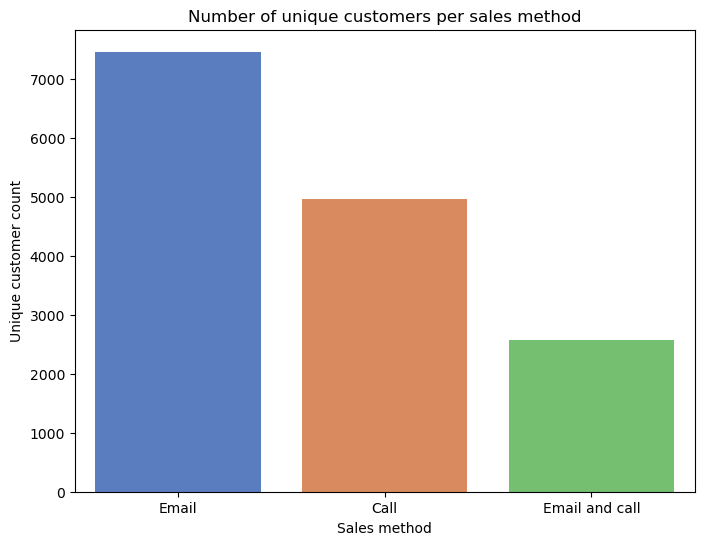

Email sales method: 7466 unique customers
Call sales method: 4962 unique customers
Email and call sales method: 2572 unique customers


In [44]:
# count of 'customer_id' for unique customer identifiers by sales_method
unique_customers_per_method = data.groupby('sales_method')['customer_id'].nunique()

# convert series to df
unique_customers_df = unique_customers_per_method.reset_index()
unique_customers_df.columns = ['Sales method', 'Unique customer count']

# define barplot order
order = ['Email', 'Call', 'Email and call']

# create plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Sales method', y='Unique customer count', data=unique_customers_df, order=order, palette='muted')
plt.title('Number of unique customers per sales method')
plt.xlabel('Sales method')
plt.ylabel('Unique customer count')
plt.show()

# print data
print('Email sales method: ' + str(unique_customers_df['Unique customer count'].iloc[1]) + ' unique customers')
print('Call sales method: ' + str(unique_customers_df['Unique customer count'].iloc[0]) + ' unique customers')
print('Email and call sales method: ' + str(unique_customers_df['Unique customer count'].iloc[2]) + ' unique customers')

#### <span style="color: red;">5.1.1 Q1 answer (based on 5.1)</span>

**Q1: How many customers were there for each approach?**

- 7466 unique customers have been reached by 'Email'
- 4962 unique customers have been reached by 'Call'
- 2572 unique customers have been reached by 'Email and call'

### 5.2 Visualization of revenue

Since there are 1704 missing values for the 'revenue' column, it could be useful to create a visualization that shows the distribution of 'revenue' in different scenarios. Additionally, as we will subsequently start analyzing and comparing the different sale methodologies ('sales_method'), it could be useful to understand the distribution of the missing values per sale methodologies.

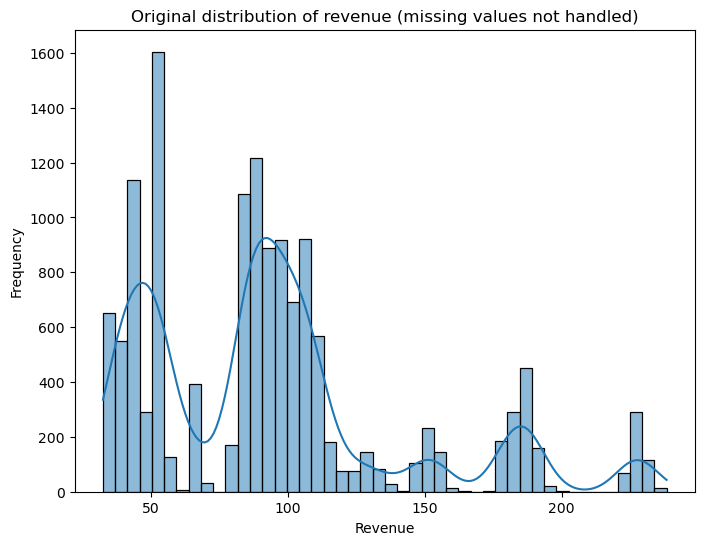

In [45]:
# original distribution disregarding null values
plt.figure(figsize=(8, 6))
sns.histplot(data['revenue'], kde=True)
plt.title('Original distribution of revenue (missing values not handled)')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

#### 5.2.1 Imputation with median

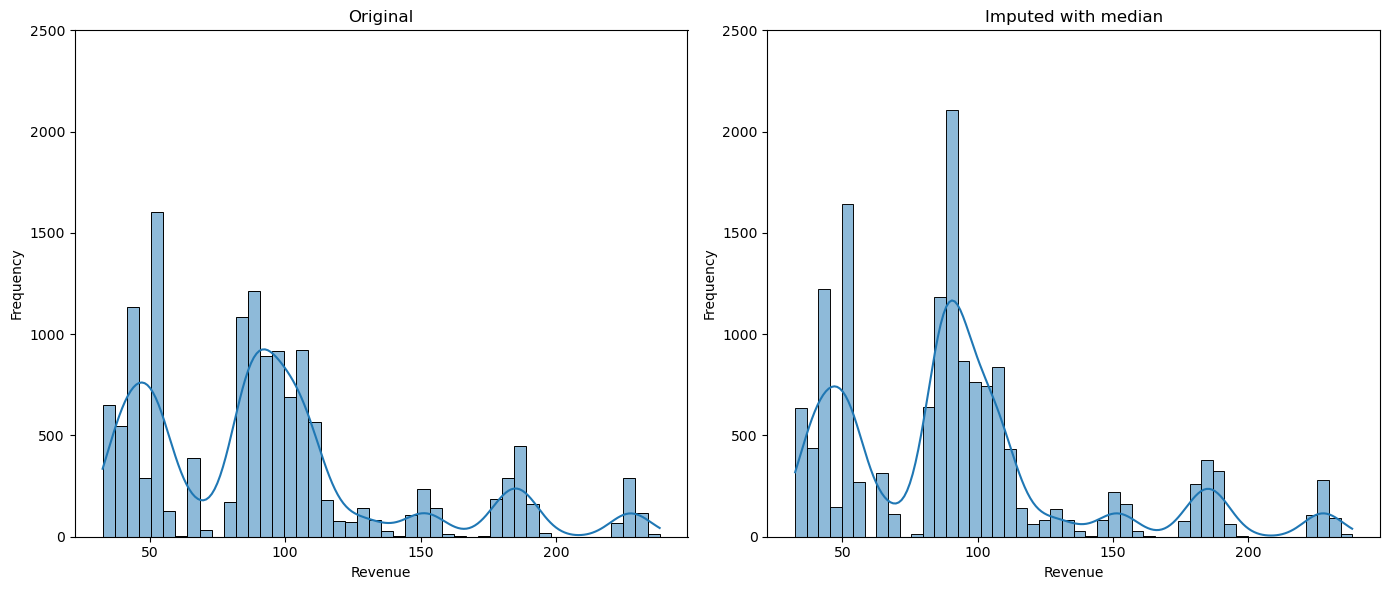

The median revenue is: 89.5


In [46]:
# original distribution vs imputation with median (best alternative for skewed distributions)

# get median revenue
median_revenue = data['revenue'].median()

# create plot with multiple subplots
plt.figure(figsize=(14, 6))

# original distribution disregarding null values
plt.subplot(1, 2, 1)
sns.histplot(data['revenue'].dropna(), kde=True)
plt.title('Original')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.ylim(0, 2500)

# imputation with median (best alternative for skewed distributions)
revenue_imputed_median = data['revenue'].fillna(median_revenue)
plt.subplot(1, 2, 2)
sns.histplot(revenue_imputed_median, kde=True)
plt.title('Imputed with median')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.ylim(0, 2500)

# show plots
plt.tight_layout()
plt.show()

# print median revenue
print('The median revenue is: ' + str(median_revenue))

Both distributions seem to have a similar overall shape, suggesting that imputation hasn't drastically altered the data's distribution. However, the spike at the median value in the imputed plot indicates the added data points.

#### 5.2.2 Revenue NaN count by sales method

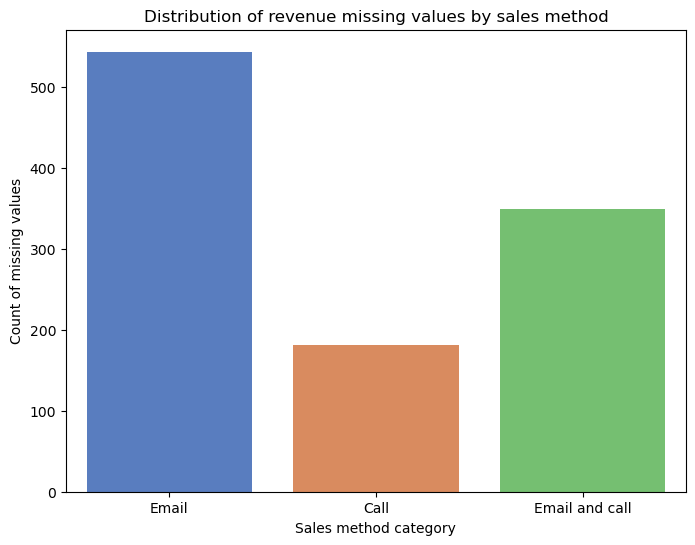

In [47]:
# filter for rows with missing 'revenue'
missing_revenue_data = data[data['revenue'].isnull()]

# count 'sales_method' occurences in the missing revenue data
missing_revenue_method = missing_revenue_data['sales_method'].value_counts()

# create visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=missing_revenue_method.index, y=missing_revenue_method.values, order=order, palette='muted')
plt.title('Distribution of revenue missing values by sales method')
plt.xlabel('Sales method category')
plt.ylabel('Count of missing values')
plt.show()

In [48]:
# check for total missing values (should be 1074)
missing_revenue_method.sum()

1074

#### 5.2.3 Revenue count by sales method (stacked)

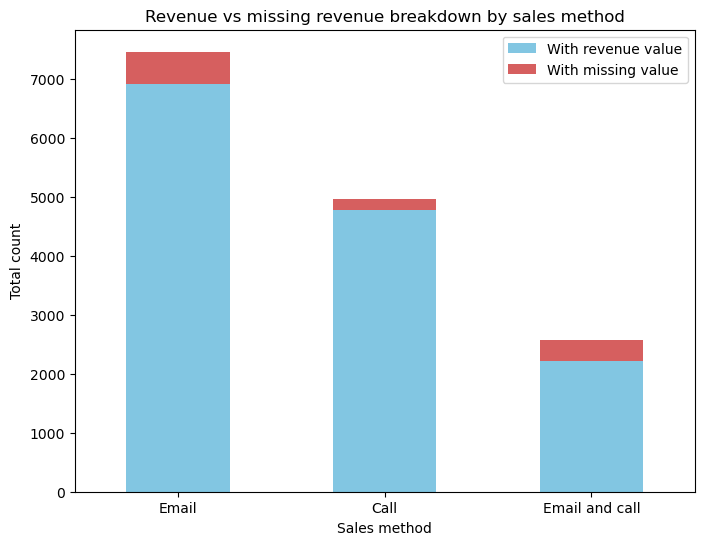

In [49]:
# count total occurences by sales method and count of missing values for each sales method
total_sales_method = data['sales_method'].value_counts()
missing_sales_method = data[data['revenue'].isnull()]['sales_method'].value_counts()

# create dataframe for visualization (entries with and without revenue value)
sales_method_df = pd.DataFrame({'With revenue value': total_sales_method - missing_sales_method, 'With missing value': missing_sales_method})
sales_method_df = sales_method_df.fillna(0)
sales_method_df = sales_method_df.reindex(order)

# create stacked bar chart
muted_colors = ['#82C6E2', '#D65F5F']
sales_method_df.plot(kind='bar', stacked=True, figsize=(8, 6), color=muted_colors)
plt.title('Revenue vs missing revenue breakdown by sales method')
plt.xlabel('Sales method')
plt.ylabel('Total count')
plt.xticks(rotation=0)
plt.show()

In [50]:
# values check
sales_method_df

,With revenue value,With missing value
Email,6922,544
Call,4781,181
Email and call,2223,349


#### 5.2.4 Revenue % of missing values by sales method

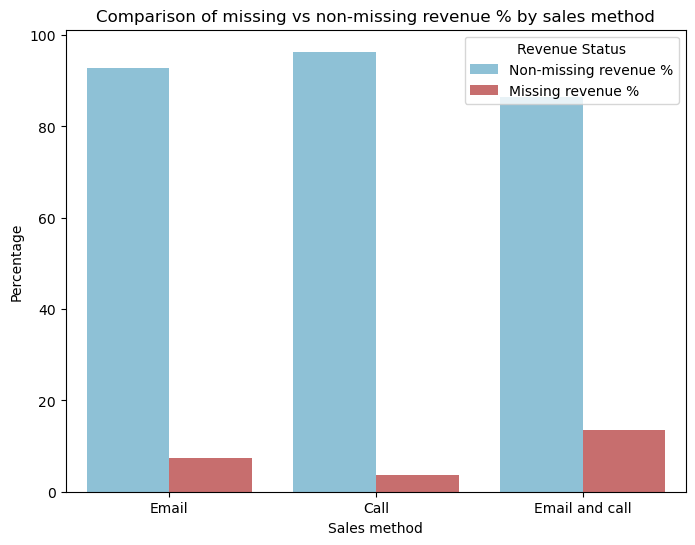

In [51]:
# calculate total occurrences for non-missing values by subtracting missing from total occurrences
non_missing_sales_method = total_sales_method - missing_sales_method

# calculate % for missing and non-missing values
sales_method_df['Non-missing revenue %'] = (non_missing_sales_method / total_sales_method) * 100
sales_method_df['Missing revenue %'] = (missing_sales_method / total_sales_method) * 100

# prepare data for plot
percentage_df = sales_method_df[['Non-missing revenue %', 'Missing revenue %']]
percentage_df = percentage_df.reset_index()
percentage_df_melted = percentage_df.melt(id_vars='index', var_name='Revenue Status', value_name='Percentage')

# create plot
plt.figure(figsize=(8, 6))
sns.barplot(x='index', y='Percentage', hue='Revenue Status', data=percentage_df_melted, palette=muted_colors)
plt.title('Comparison of missing vs non-missing revenue % by sales method')
plt.xlabel('Sales method')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [52]:
missing_sales_method

Email             544
Email and call    349
Call              181
Name: sales_method, dtype: int64

In [53]:
# 'revenue' dataframe overview
sales_method_df

,With revenue value,With missing value,Non-missing revenue %,Missing revenue %
Email,6922,544,92.713635,7.286365
Call,4781,181,96.352277,3.647723
Email and call,2223,349,86.430793,13.569207


**Considerations for 'revenue' missing data:**

- The % of missing values varies significantly among sales method, with 'Email and call' notably higher
- The missing data could skew the results, especially if the reason is not random
- A further investigation for the cause of those missing values might be needed
- Further analysis into the pattern of the missing values (check if missingness correlates vith other variables)

#### 5.2.5 Sensitivity and correlation analysis

In [54]:
# sensitivity analysis before vs after imputation
summary_original = data['revenue'].describe()
summary_imputed = revenue_imputed_median.describe()

# correlation before vs after imputation
correlation_original = data.corr()['revenue']
correlation_imputed = data.assign(revenue_imputed=revenue_imputed_median).corr()['revenue_imputed']

# display summary statistics and correlation comparisons
summary_comparison = pd.DataFrame({'Original': summary_original, 'Imputed': summary_imputed})
correlation_comparison = pd.DataFrame({'Original': correlation_original, 'Imputed': correlation_imputed})

# drop self correlation
summary_comparison, correlation_comparison.drop('revenue_imputed')

(           Original       Imputed
 count  13926.000000  15000.000000
 mean      93.934943     93.617401
 std       47.435312     45.719775
 min       32.540000     32.540000
 25%       52.470000     53.040000
 50%       89.500000     89.500000
 75%      107.327500    106.070000
 max      238.320000    238.320000,
                    Original   Imputed
 nb_site_visits     0.323089  0.309244
 nb_sold            0.696165  0.660017
 revenue            1.000000  1.000000
 week               0.356179  0.340800
 years_as_customer -0.064873 -0.062276)

**Worth mentioning about sensitivity and correlation:**

- Both distributions seem to have a similar overall shape, but the i puted has a spike at median value
- The mean and std are slightly lower in the imputed dataset
- The 25% and 75% quartiles show minor differences
- The correlation values are slightly lower in the imputed dataset for all variables

### 5.3 Spread of revenue

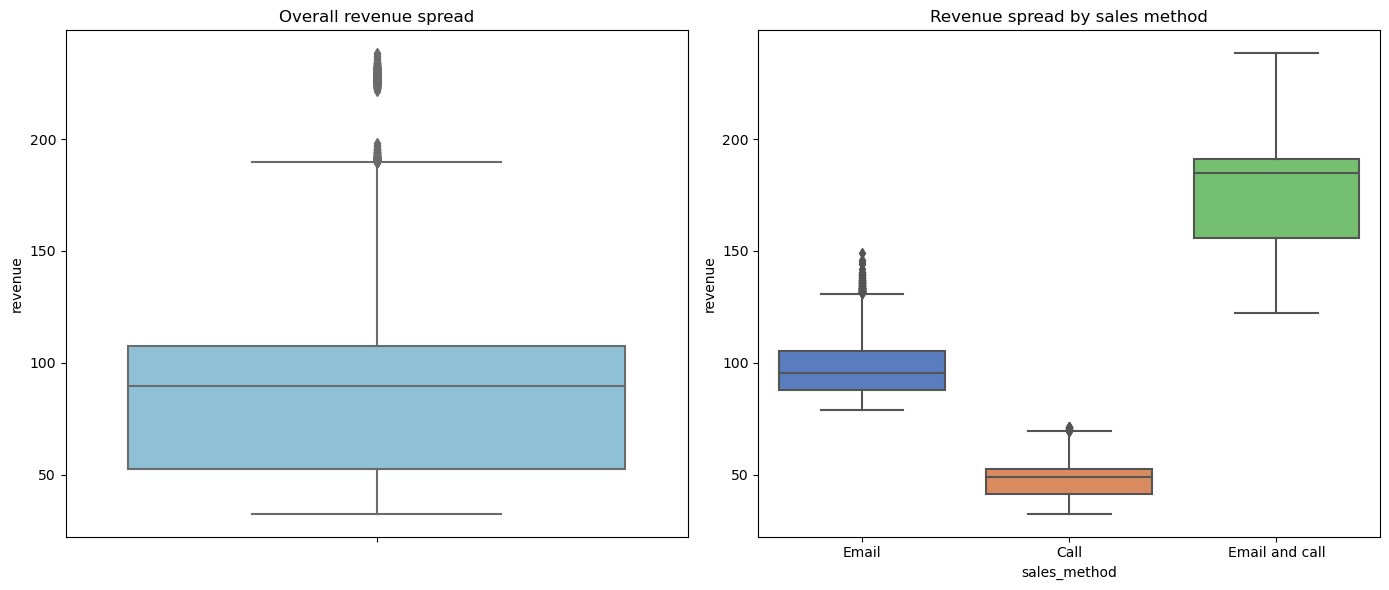

In [55]:
# overall revenue spread
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=data['revenue'], color='#82C6E2')
plt.title('Overall revenue spread')

# revenue spread by sales_method
plt.subplot(1, 2, 2)
sns.boxplot(x='sales_method', y='revenue', order=order, data=data, palette='muted')
plt.title('Revenue spread by sales method')

#plot
plt.tight_layout()
plt.show()

In [56]:
# descriptive stats for overall revenue (same as initial basic EDA)
overall_stats = data['revenue'].describe()

# convert series to dataframe
overall_stats_df = overall_stats.to_frame()
overall_stats_df.columns = ['overall']

# calculate IQR spread for overall revenue
iqr = overall_stats['75%'] - overall_stats['25%']

# add IQR spread to dataframe
overall_stats_df.loc['IQR'] = iqr

overall_stats_df = overall_stats_df.T

# show df
overall_stats_df

,count,mean,std,min,25%,50%,75%,max,IQR
overall,13926.0,93.934943,47.435312,32.54,52.47,89.5,107.3275,238.32,54.8575


In [57]:
# descriptive statistics for the revenue by each sales method
method_stats = data.groupby('sales_method')['revenue'].describe()

# index reset to turn multi-index series into a dataframe
method_stats_df = method_stats.reset_index()

# add IQR spread to dataframe
method_stats_df['IQR'] = method_stats_df['75%'] - method_stats_df['25%']

# show df
method_stats_df

,sales_method,count,mean,std,min,25%,50%,75%,max,IQR
0,Call,4781.0,47.597467,8.609899,32.54,41.470,49.07,52.68,71.36,11.210
1,Email,6922.0,97.127684,11.210469,78.83,87.880,95.58,105.17,148.97,17.290
2,Email and call,2223.0,183.651233,29.083924,122.11,155.775,184.74,191.11,238.32,35.335


#### <span style="color: red;">5.3.1 Q2 answer (based on 5.3)</span>

**Q2: What does the spread of the revenue look like overall? And for each method?**

**Considerations for 'revenue' spread:**

- Overall 'revenue' has a considerable spread (IQR method) of 54.85
- The value range is from 32.54 to 238.32, indicating diverse revenue amounts across all revenues
- Median is 89.50, which suggests that half of the sales transactions generate less than this amount
- IQR, from 52.47 to 107.33, captures the middle 50% of the revenue data
- There is a significant numbe of outliers, particularly on the higher end, which indicates that there are several instances where revenue is exceptionally high

**Considerations for 'revenue' spread by sales method:**

- 'Email': broather IQR than 'Call' but narrower than 'Email and call' (moderate variability in revenue)
- 'Email': median value is higher than the 'Call' method (95.58 vs 49.07), meaning email method generates typically more revenue per sale
- 'Email': outliers are present indicating occasional higher revenue sales
- 'Call': smallest IQR among the sales methods, indicating more consistent sales outcomes
- 'Call': median revenue is the lowest with 49.07 (less revenue per sale)
- 'Call': fewer outliers compared to other sales methods
- 'Call': rarely results in very high revenues
- 'Email and call': widerst IQR, showing the greatest variability in revenue among the three methods
- 'Email and call': highest median revenue (184.74), which indicates its potential to generate high revneue per sale
- 'Email and call': presence of high-revenue outliers is significant, suggesting that the combined method is effective

### 5.4 Correlation analysis

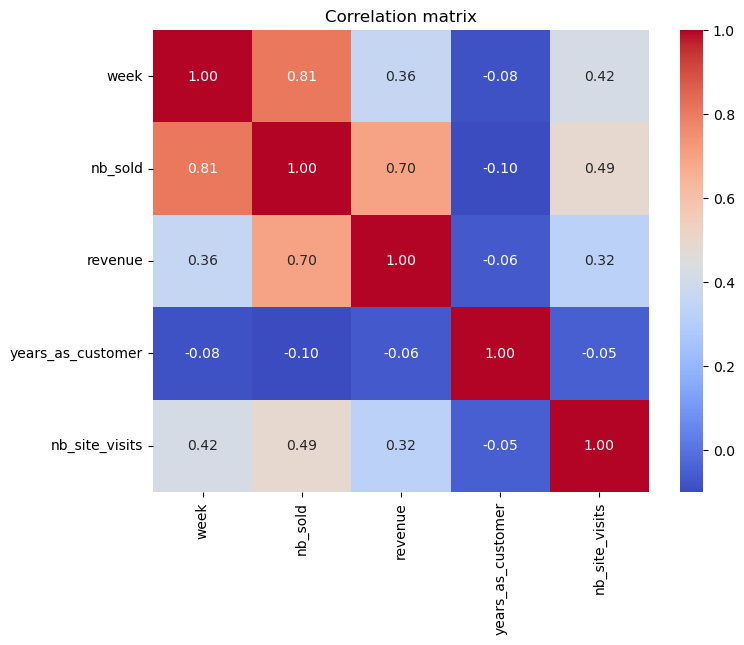

In [58]:
# create correlation matrix
correlation_matrix = data.corr()

# plot correlation matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

**Considerations for correlation heatmap:**

- Correlation between 'nb_sold' and 'revenue' is positive and strong, as expected (more sales higher revenue)
- Correlation between 'nb_sold' and 'week' is positive and strong (might be due do an initial ramp-up phase where sales are increasing week by week)
- Correlation between 'nb_site_visits' and both 'revenue' and 'nb_sold' is positive and moderate (more site visits might be associated with higher sales and revenue, indicating potential customer engagement)
- Correlation between 'years_as_customer' and 'revenue' is weak and negative (new customers might be generating more revenue initially)

### 5.5 Sales methods impact over time

#### 5.5.1 Revenue over time vs n. units sold and vs. n. site visits

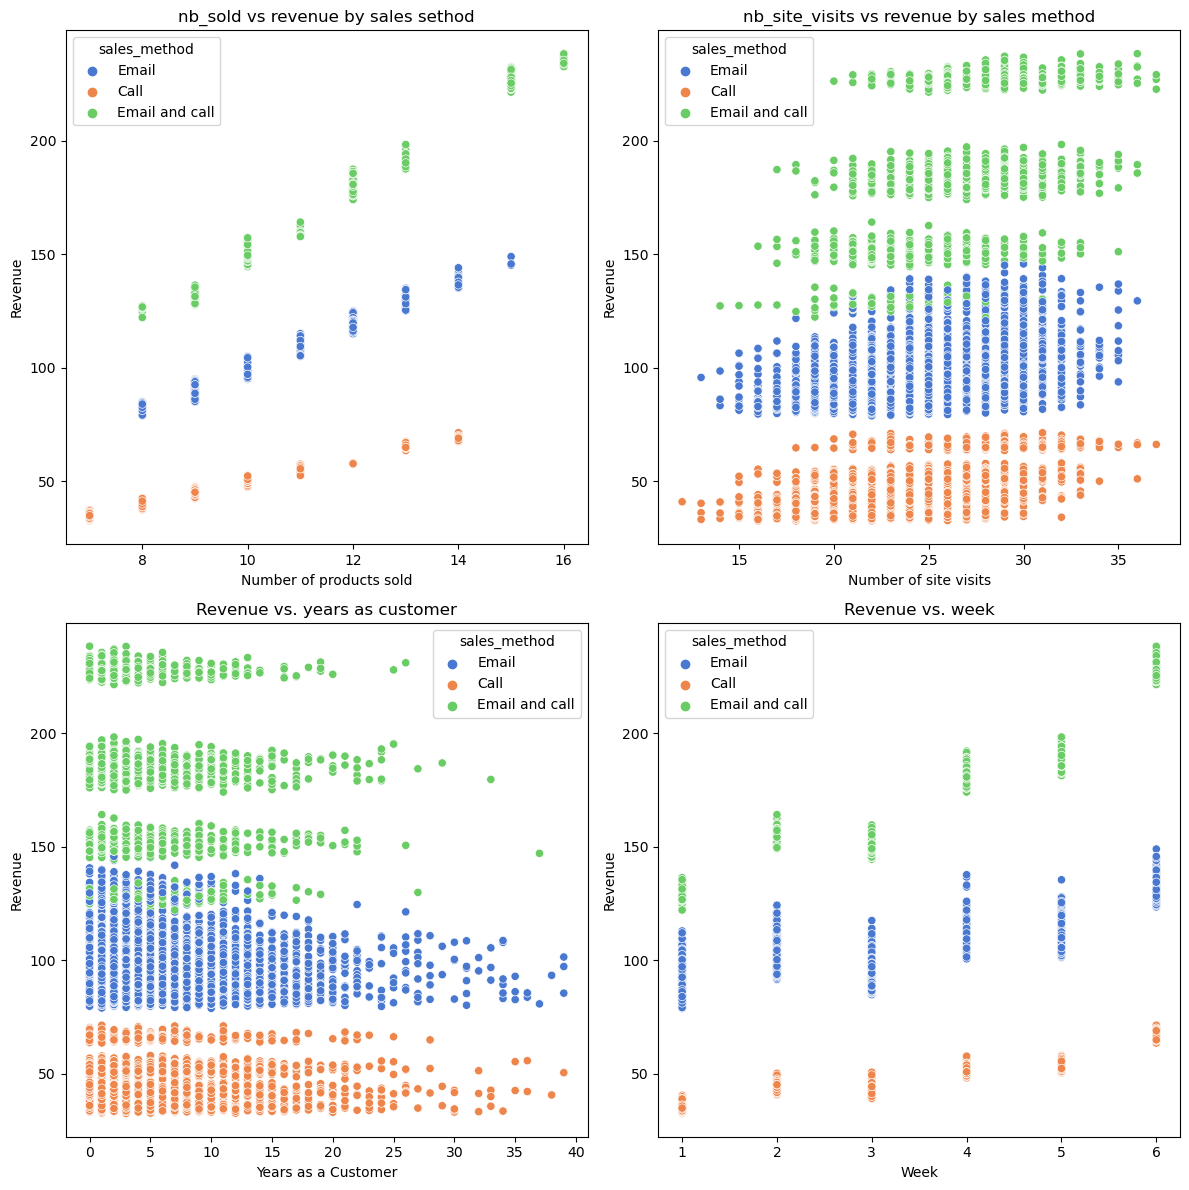

In [59]:
# create scatter plot 'nb_sold' vs 'revenue' and 'nb_site_visits' vs 'revenue', colored by sales_method

# create figure
plt.figure(figsize=(12, 12))

# 'nb_sold' vs 'revenue', colored by sales_method
plt.subplot(2, 2, 1)
sns.scatterplot(x='nb_sold', y='revenue', hue='sales_method', hue_order=order, data=data, palette='muted')
plt.title('nb_sold vs revenue by sales sethod')
plt.xlabel('Number of products sold')
plt.ylabel('Revenue')

# 'nb_site_visits' vs 'revenue', colored by sales_method
plt.subplot(2, 2, 2)
sns.scatterplot(x='nb_site_visits', y='revenue', hue='sales_method', hue_order=order, data=data, palette='muted')
plt.title('nb_site_visits vs revenue by sales method')
plt.xlabel('Number of site visits')
plt.ylabel('Revenue')

# 'revenue' vs 'years_as_customer', colored by sales_method
plt.subplot(2, 2, 3)
sns.scatterplot(x='years_as_customer', y='revenue', hue='sales_method', hue_order=order, data=data, palette='muted')
plt.title('Revenue vs. years as customer')
plt.xlabel('Years as a Customer')
plt.ylabel('Revenue')

# 'revenue' vs 'week', colored by sales_method
plt.subplot(2, 2, 4)
sns.scatterplot(x='week', y='revenue', hue='sales_method', hue_order=order, data=data, palette='muted')
plt.title('Revenue vs. week')
plt.xlabel('Week')
plt.ylabel('Revenue')

# plot
plt.tight_layout()
plt.show()

#### 5.5.2 Grouped analysis by sales_method

In [60]:
# grouped analysis by sales_method
grouped_data = data.groupby('sales_method').agg({'revenue': ['mean', 'median', 'sum'],
                                                 'nb_sold': ['mean', 'median', 'sum'],
                                                 'nb_site_visits': ['mean', 'median']})

# get columns, reset index and print
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]
grouped_data.reset_index(inplace=True)
grouped_data

,sales_method,revenue_mean,revenue_median,revenue_sum,nb_sold_mean,nb_sold_median,nb_sold_sum,nb_site_visits_mean,nb_site_visits_median
0,Call,47.597467,49.07,227563.49,9.509674,10.0,47187,24.423821,24.0
1,Email,97.127684,95.58,672317.83,9.729306,10.0,72639,24.754353,25.0
2,Email and call,183.651233,184.74,408256.69,12.225505,12.0,31444,26.771384,27.0


#### <span style="color: red;">5.5.3 Q3 answer (based on 5.5)</span>

**Q3: Was there any difference in revenue over time for each of the methods?**

**Considerations for revenue over time vs n. units sold and vs. n. site visits:**

- 'nb_sold' vs 'revenue': positive relationship evident across all sales methods, with 'Email and call' category having the highest revenues at all nb_sold levels (more effective)
- 'nb_site_visits' vs 'revenue': relationship less pronounced, with 'Email and call' highest revenue category
- 'revenue' vs 'years_as_customer': relationship is not straightforward but the plot further confirms better revenue generation for 'Email and call' sales_method, then 'Email' and 'Call'
- 'revenue' vs' week': increasing revenue week over week for all categories

**Considerations for grouped analysis by sales_method:**

- 'Email and call' outperforms both 'Email' and 'Call' sales methods in terms of average and median revenue
- 'revenue_sum' shows that despite the higher average of 'Email and call', the 'Email' method led to the highest total revenue (due to the larger number of transaction made through the 'Email' method
- 'nb_sold' mean and median demonstrate the higher effectiveness (more product per trnasaction and more revenue per sale)
- 'nb_sold_sum', similar to 'revenue_sum', shows 'Email' as the highest products sold method (due once again to the larger number of transactions)
- 'nb_site_visits' mean and median are higher once again for 'Email and call' sales method category (could suggest better engagement or more effective marketing strategies with the combined approach)

### 5.6 Time series analysis

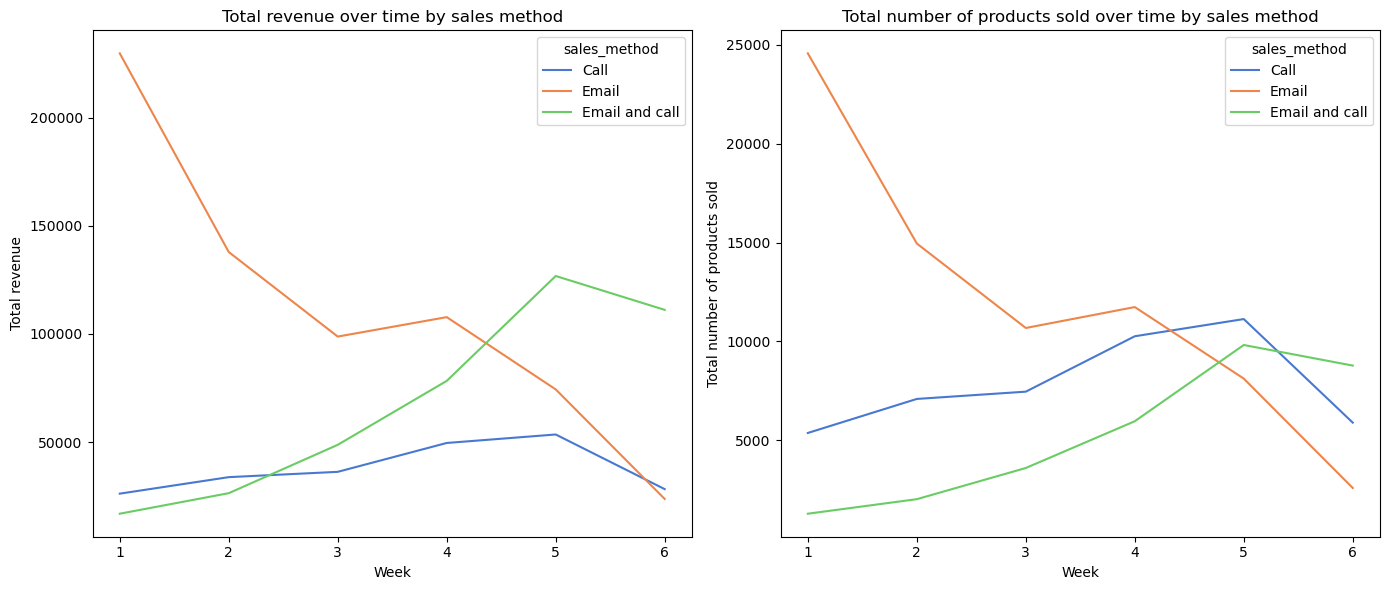

In [61]:
# aggregate metrics by week and sales_method
weekly_aggregate_by_method_filtered = data.groupby(['week', 'sales_method']).agg({
    'revenue': 'sum',
    'nb_sold': 'sum'
}).reset_index()

# visualize trends over time by sales_method
plt.figure(figsize=(14, 6))

# revenue over time by sales_method
plt.subplot(1, 2, 1)
sns.lineplot(x='week', y='revenue', hue='sales_method', data=weekly_aggregate_by_method_filtered, palette='muted')
plt.title('Total revenue over time by sales method')
plt.xlabel('Week')
plt.ylabel('Total revenue')

# number of products sold over time by sales_method
plt.subplot(1, 2, 2)
sns.lineplot(x='week', y='nb_sold', hue='sales_method', data=weekly_aggregate_by_method_filtered, palette='muted')
plt.title('Total number of products sold over time by sales method')
plt.xlabel('Week')
plt.ylabel('Total number of products sold')

# plot
plt.tight_layout()
plt.show()

**Considerations for revenue over time by sales method:**

- The revenue trends for each sales method vary notabily over the weeks
- 'Email' method performance has been drastically decreasing week over week (WOW)
- 'Call' method generally shows lower revenue than other methods
- 'Email and call' method shows an significant increase WOW, suggesting in might be more effective in generating higher revenue per sale in the future

**Considerations for number of products sold over time by sales method:**

- The number of products sold trends for each sales method vary notabily over the weeks
- 'Email' method is performing worse and worse WOW
- 'Call' method still contributes a significat volume of sales
- 'Email and call' method shows an increase in effectiveness WOW an significant increase WOW

**Overall consideration for time series analysis:**

- Based on these insights, a strategic focus on 'Email and call' method for future sales initiatives could be advisable, particularly when aiming to maximize revenue and sales volume
- The 'Email and call' method appears to capitalize on the strenghts of both individual sales methods, prividing both reach and personalized engagement, which seems to resonate effectively with customers

### 5.7 Group by state and sales method insights

In [62]:
# group data by state and sales_method
sales_method_effectiveness = data.groupby(['state', 'sales_method']).agg({
    'revenue': ['mean', 'sum'],
    'nb_sold': ['mean', 'sum']
}).reset_index()

# flatten multi level column names
sales_method_effectiveness.columns = ['_'.join(col).rstrip('_') if col[1] else col[0] for col in sales_method_effectiveness.columns.values]

# covert 'sales_method' to categorcal to order categories as previous analysis
sales_method_effectiveness['sales_method'] = pd.Categorical(
    sales_method_effectiveness['sales_method'], 
    categories=["Email", "Call", "Email and call"], 
    ordered=True
)

# sort the data for visualization and analysis
sales_method_effectiveness_sorted = sales_method_effectiveness.sort_values(by=['state', 'sales_method'], ascending=True)

# display top rows to check
sales_method_effectiveness_sorted.head()

,state,sales_method,revenue_mean,revenue_sum,nb_sold_mean,nb_sold_sum
1,Alabama,Email,96.841028,10361.99,9.678571,1084
0,Alabama,Call,46.421311,2831.70,9.380952,591
2,Alabama,Email and call,187.946176,6390.17,12.461538,486
4,Alaska,Email,101.971111,1835.48,10.047619,211
3,Alaska,Call,48.784615,634.20,9.846154,128


In [63]:
# create pivot table
pivot_table = sales_method_effectiveness.pivot_table(
    index='state', 
    columns='sales_method', 
    values='revenue_mean'
)

# create boolean column
pivot_table['condition_met'] = (
    (pivot_table['Email and call'] > pivot_table['Email']) & 
    (pivot_table['Email'] > pivot_table['Call'])
)

# rename columns
pivot_table = pivot_table.rename(columns={'Email': 'email', 'Call': 'call', 'Email and call': 'email_and_call'})

# reset index
pivot_table.reset_index(inplace=True)

# display results
pivot_table


sales_method,state,email,call,email_and_call,condition_met
0,Alabama,96.841028,46.421311,187.946176,True
1,Alaska,101.971111,48.784615,182.577500,True
2,Arizona,96.878881,48.381875,179.604898,True
3,Arkansas,94.138367,46.676939,194.771500,True
4,California,97.267029,47.896312,183.018897,True
5,Colorado,96.871351,48.723099,177.780667,True
6,Connecticut,97.677639,46.211379,179.448649,True
7,Delaware,98.732857,42.682857,183.296667,True
8,Florida,97.372500,48.780105,182.625038,True
9,Georgia,97.590164,46.804392,186.578824,True


**Overall consideration 'state' vs 'sales_method' grouped analysis:**

- The pivot table above with check, with a boolean value, if the category 'Email and call' performs better in terms of revenue when compared to 'Email', and then 'Call'
- The mean revenue in each state is always higher for 'Email and call', no difference across states

In [64]:
# WIP